In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, types
from numba.typed import Dict, List

In [2]:
#Lets try loading in the hit-wise reco:
data = np.load('hitwise_detector_sim_0002459.npz')
neutrino_vertices = data['first']
hit_array = data['second']

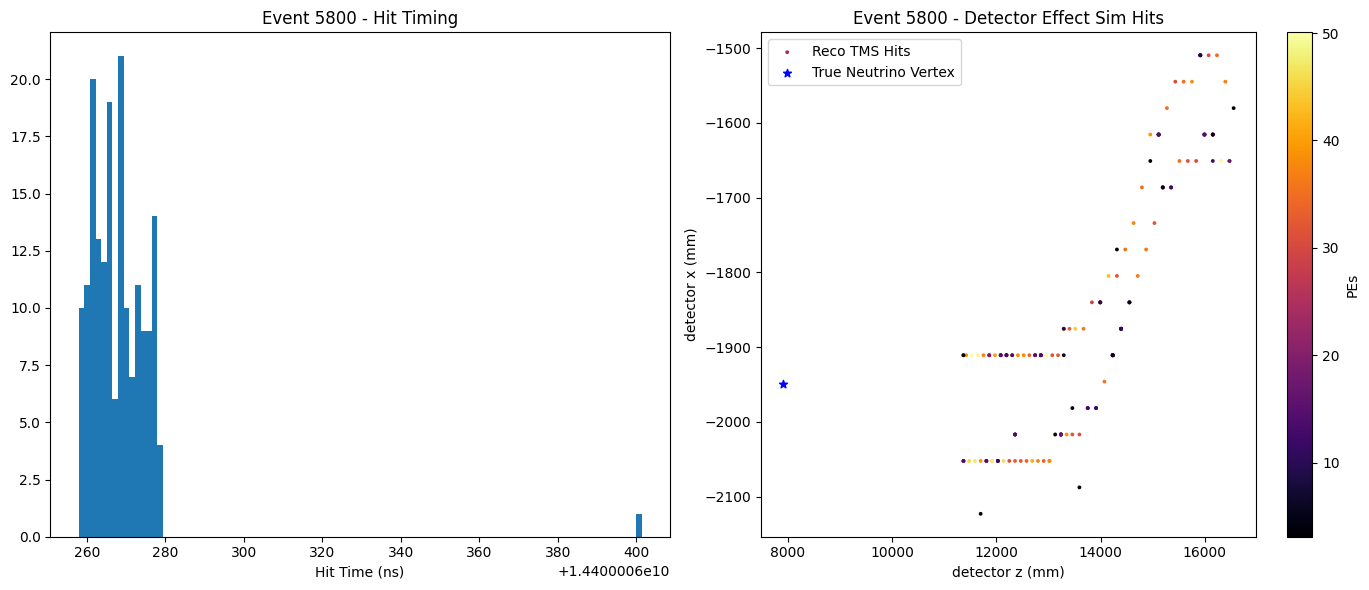

In [3]:
#Let's try and replicate some plots, to show successful data transfer - looks ok!

event_number_example = 5800

# Reco hit data
reco_hit_xs = []
reco_hit_zs = []
reco_hit_PEs = []
reco_hit_Ts = []

for hit in hit_array:
    if (hit[0] == event_number_example):
        reco_hit_xs.append(hit[2])
        reco_hit_zs.append(hit[4])
        reco_hit_Ts.append(hit[5])
        reco_hit_PEs.append(hit[6])

event_neutrino = [vtx for vtx in neutrino_vertices if vtx[0] == event_number_example]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot reco hits
sc2 = ax2.scatter(reco_hit_zs, reco_hit_xs, s=3, c=reco_hit_PEs, cmap='inferno', label='Reco TMS Hits')
ax2.scatter(event_neutrino[0][3], event_neutrino[0][1], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax2.set_xlabel("detector z (mm)")
ax2.set_ylabel("detector x (mm)")
ax2.set_title(f"Event {event_number_example} - Detector Effect Sim Hits")
ax2.legend()
fig.colorbar(sc2, ax=ax2, label='PEs')

# Plot truth hits
sc1 = ax1.hist(reco_hit_Ts, bins=100)
ax1.set_xlabel("Hit Time (ns)")
ax1.set_title(f"Event {event_number_example} - Hit Timing")

plt.tight_layout()
plt.show()


In [78]:
#Great so we seem to have preserved all of our information - lets try some processing now, and we can hopefully use numba to make it faster. 

In [4]:
#A largely chat-gpt inspired function that creates a dictionary keyed by unique (x,z) hold the indices of the hit_array with that key, 
def sort_by_bar(hit_array):
    N = hit_array.shape[0]

    # Group hits by (x, z)
    group_dict = Dict.empty(
        key_type=types.UniTuple(types.float64, 2),
        value_type=types.ListType(types.int64)
    )

    for i in range(N):
        x = hit_array[i, 2]
        z = hit_array[i, 4]
        key = (x, z)
        if key not in group_dict:
            group_dict[key] = List.empty_list(types.int64)
        group_dict[key].append(i)
        
    return(group_dict)


In [5]:
bar_dictionary = sort_by_bar(hit_array)

In [9]:
%%time
coincident_pairs = 0 
total_objects = 0
for key in bar_dictionary:
    readout_window = 120
    index_list = bar_dictionary[key]
    total_objects += len(index_list)
    times = [hit_array[i][5] for i in index_list]
    sorted_idx = np.argsort(times) #returns indixes that would sort a list. - not matched to hits
    sorted_times = [times[i] for i in sorted_idx] #times sorted by times
    sorted_indices = [index_list[i] for i in sorted_idx] #return sorted list of hit indices
    start = 0
    time_index_array = np.column_stack((sorted_times, sorted_indices)) #perhaps a useful object
    groups = []
    current_group = [int(time_index_array[0][1])]
    t_start = time_index_array[0][0]

    for i in range(1, time_index_array.shape[0]):
        t = time_index_array[i][0]
        idx = int(time_index_array[i][1])

        if t - t_start <= readout_window:
            current_group.append(idx)
        else:
            groups.append(current_group)
            current_group = [idx]
            t_start = t

    # Add the final group
    if current_group:
        groups.append(current_group)

    # Print result
    for i, group in enumerate(groups):
        print(f"Key {key} - Group {i}: {group}")

   
            
   

CPU times: user 2.75 s, sys: 58.5 ms, total: 2.81 s
Wall time: 2.83 s


In [7]:
#single key test. 
index_list = bar_dictionary[(-1120.3659359075525, 11588.0)]
readout_window = 120
times = [hit_array[i][5] for i in index_list]
sorted_idx = np.argsort(times) #returns indixes that would sort a list. - not matched to hits
sorted_times = [times[i] for i in sorted_idx] #times sorted by times
sorted_indices = [index_list[i] for i in sorted_idx] #return sorted list of hit indices
time_index_array = np.column_stack((sorted_times, sorted_indices))

groups = []
current_group = [int(time_index_array[0][1])]
t_start = time_index_array[0][0]

for i in range(1, time_index_array.shape[0]):
    t = time_index_array[i][0]
    idx = int(time_index_array[i][1])

    if t - t_start <= readout_window:
        current_group.append(idx)
    else:
        groups.append(current_group)
        current_group = [idx]
        t_start = t

# Add the final group
if current_group:
    groups.append(current_group)

# Print result
for i, group in enumerate(groups):
    print(f"Group {i}: {group}")

Group 0: [0]
Group 1: [184433, 184432, 184501]
Group 2: [210991, 211034, 210993, 210992, 211035, 211036]
